# Model figures for all populations

## Import and define functions
[back to top](#Summarize-models)

In [1]:
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style("white")
plt.style.use("huddlej")

In [3]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [4]:
colors = ['#d73027','#fc8d59','#fee090','#e0f3f8','#91bfdb','#4575b4']

In [5]:
colors.reverse()

In [6]:
colors

['#4575b4', '#91bfdb', '#e0f3f8', '#fee090', '#fc8d59', '#d73027']

In [7]:
ncols = 2
color_by_predictor = {
    'fitness': '#000000',
    'ep': '#4575b4',
    'ep_star': '#4575b4',
    'ep_x': '#4575b4',
    'cTiter': '#91bfdb',
    'cTiterSub': '#91bfdb',
    'cTiterSub_star': '#91bfdb',
    'cTiterSub_x': '#91bfdb',
    'ne_star': '#999999',
    'dms_star': '#fee090',
    'lbi': '#fc8d59',
    'delta_frequency': '#d73027'
}

name_by_predictor = {
    "fitness": "true fitness",
    "ep": "epitope mutations",
    "ep_star": "epitope ancestor",
    "ep_x": "cross-immunity",
    "cTiter": "linear HI tree phenotypes",
    "cTiterSub": "linear HI mutation phenotypes",
    "cTiterSub_star": "ancestral HI mutation phenotypes",
    "cTiterSub_x": "HI phenotypes",
    "ne_star": "non-epitope mutations",
    "dms_star": "DMS phenotypes",
    "lbi": "LBI",
    "delta_frequency": "delta frequency"
}

In [8]:
def get_individual_predictors_for_data_frame(df):
    return [
        predictor
        for predictor in df["predictors"].unique()
        if "-" not in predictor and predictor != "naive"
    ]

def get_composite_predictors_for_data_frame(df):
    return [
        predictor
        for predictor in df["predictors"].unique()
        if "-" in predictor
    ]

In [33]:
def plot_accuracy_and_coefficients_for_build(errors_by_time_df, coefficients_by_time_df, predictors, rotation=30,
                                             years_fmt_string="%Y", date_fmt_string="%Y-%m", height=12, width=12):
    # Determine bounds for given data to set axes domains and ranges.
    min_normal_error = errors_by_time_df["validation_error"].min()
    max_normal_error = errors_by_time_df["validation_error"].max()

    min_coefficient = coefficients_by_time_df["coefficient"].min()
    max_coefficient = coefficients_by_time_df["coefficient"].max()

    min_date = errors_by_time_df["validation_timepoint"].min() - pd.DateOffset(months=6)
    max_date = errors_by_time_df["validation_timepoint"].max() + pd.DateOffset(months=6)
    
    nrows = len(predictors)
    
    fig, axes = plt.subplots(figsize=(width, height), facecolor='w')
    gs = gridspec.GridSpec(
        nrows=nrows,
        ncols=ncols,
        hspace=0.1,
        wspace=0.2
    )

    years = mdates.YearLocator()
    years_fmt = mdates.DateFormatter(years_fmt_string)
    months = mdates.MonthLocator()

    naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()

    for i, predictor in enumerate(predictors):
        error_df = errors_by_time_df[errors_by_time_df["predictors"] == predictor].copy()
        coefficient_df = coefficients_by_time_df[coefficients_by_time_df["predictors"] == predictor].copy()
        
        composite_predictors = predictor.split("-")
        composite_predictors_name = " + ".join([name_by_predictor[predictor_name] for predictor_name in composite_predictors])

        distance_ax = plt.subplot(gs[i, 0])    
        distance_ax.set_xlabel("Date")
        distance_ax.set_ylabel("Distance\nto future")
        distance_ax.set_ylim(-0.5, 0.8)
        distance_ax.text(
            0.025,
            0.9,
            "%s: %.2f +/- %.2f" % (composite_predictors_name, error_df["validation_error"].mean(), error_df["validation_error"].std()),
            fontdict={"fontsize": 12},
            transform=distance_ax.transAxes
        )

        distance_ax.axhline(
            y=0.0,
            color="#cccccc"
        )

        distance_ax.plot(
            pd.to_datetime(naive_error_df["validation_timepoint"]).astype(np.datetime64),
            naive_error_df["validation_error"],
            "o-",
            color="#cccccc",
            zorder=-10
        )

        distance_ax.plot(
            pd.to_datetime(error_df["validation_timepoint"]).astype(np.datetime64),
            error_df["validation_error"],
            "o-",
            color="#000000"
        )

        distance_ax.set_xlim(min_date, max_date)
        distance_ax.xaxis.set_major_locator(years)
        distance_ax.xaxis.set_major_formatter(years_fmt)
        distance_ax.xaxis.set_minor_locator(months)
        distance_ax.format_xdata = mdates.DateFormatter(date_fmt_string)

        coefficient_ax = plt.subplot(gs[i, 1])
        coefficient_ax.set_xlabel("Date")
        coefficient_ax.set_ylabel("Coefficient")
        coefficient_ax.set_ylim(min_coefficient - 1, max_coefficient + 2)

        offset = 0.9
        for individual_predictor, individual_predictor_df in coefficient_df.groupby("predictor"):
            coefficient_ax.text(
                0.025,
                offset,
                "%s: %.2f +/- %.2f" % (
                    name_by_predictor[individual_predictor],
                    individual_predictor_df["coefficient"].mean(),
                    individual_predictor_df["coefficient"].std()
                ),
                fontdict={"fontsize": 12},
                transform=coefficient_ax.transAxes
            )
            offset = offset - 0.12

        coefficient_ax.axhline(
            y=0.0,
            color="#cccccc"
        )
        
        for predictor, predictor_coefficient_df in coefficient_df.groupby("predictor"):
            coefficient_ax.plot(
                predictor_coefficient_df["validation_timepoint"],
                predictor_coefficient_df["coefficient"],
                "o-",
                color=color_by_predictor[predictor]
            )

        coefficient_ax.set_xlim(min_date, max_date)
        coefficient_ax.xaxis.set_major_locator(years)
        coefficient_ax.xaxis.set_major_formatter(years_fmt)
        coefficient_ax.xaxis.set_minor_locator(months)
        coefficient_ax.format_xdata = mdates.DateFormatter('%Y-%m')

    fig.autofmt_xdate(rotation=rotation)
    gs.tight_layout(fig)
    # show x-axis tick lines
    
    return (fig, axes, gs)

## Load data

In [10]:
simulated_sample = "simulated_sample_0"
natural_sample = "natural_sample_0_with_20_vpm"
luksza_sample = "luksza_lassig"

In [11]:
errors_file = "../results/distance_model_errors.tsv"
coefficients_file = "../results/distance_model_coefficients.tsv"

In [12]:
errors_by_time_df = pd.read_csv(errors_file, sep="\t", parse_dates=["validation_timepoint"])

In [13]:
errors_by_time_df["sample"].unique()

array(['simulated_sample_0', 'luksza_lassig',
       'natural_sample_1_with_10_vpm', 'natural_sample_0_with_20_vpm'],
      dtype=object)

In [14]:
errors_by_time_df = pd.read_csv(errors_file, sep="\t", parse_dates=["validation_timepoint"])
simulated_errors_by_time_df = errors_by_time_df[errors_by_time_df["type"] == "simulated"].copy()
natural_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == "natural_sample_1_with_10_vpm"].copy()
luksza_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == "luksza_lassig"].copy()

natural_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == natural_sample].copy()

In [15]:
simulated_errors_by_time_df.shape

(184, 6)

In [16]:
natural_errors_by_time_df.shape

(300, 6)

In [17]:
luksza_errors_by_time_df.shape

(138, 6)

In [18]:
coefficients_by_time_df = pd.read_csv(coefficients_file, sep="\t", parse_dates=["validation_timepoint"])
simulated_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == simulated_sample].copy()
natural_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == natural_sample].copy()
luksza_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == luksza_sample].copy()

In [19]:
simulated_coefficients_by_time_df.shape

(253, 6)

In [20]:
natural_coefficients_by_time_df.shape

(375, 6)

In [21]:
luksza_coefficients_by_time_df.shape

(207, 6)

In [22]:
get_individual_predictors_for_data_frame(natural_errors_by_time_df)

['ep',
 'ep_x',
 'cTiter',
 'cTiterSub',
 'cTiterSub_x',
 'ne_star',
 'dms_star',
 'lbi',
 'delta_frequency']

## Distance to the future

### Simulated populations

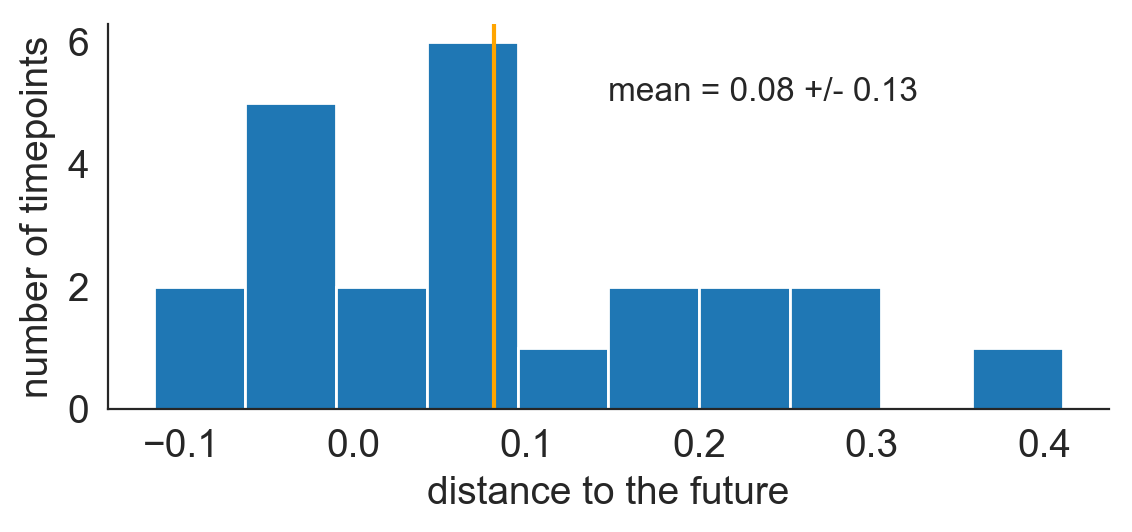

In [23]:
naive_simulated_errors_by_time_df = simulated_errors_by_time_df[simulated_errors_by_time_df["predictors"] == "naive"]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(naive_simulated_errors_by_time_df, bins=10)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_simulated_errors_by_time_df.mean()
std_y = naive_simulated_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange"
)

ax.text(
    0.5,
    0.8,
    "mean = %.2f +/- %.2f" % (mean_y, std_y),
    transform=ax.transAxes,
    fontsize=12,
    horizontalalignment="left"
)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-simulated-populations-between-timepoints.png")

### Natural populations

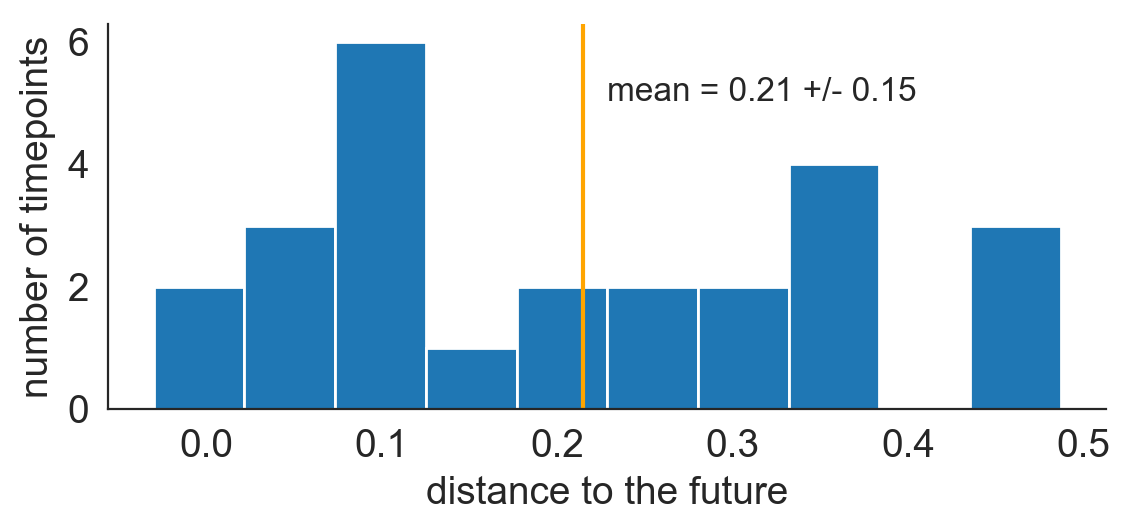

In [24]:
naive_natural_errors_by_time_df = natural_errors_by_time_df[natural_errors_by_time_df["predictors"] == "naive"]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(naive_natural_errors_by_time_df, bins=10)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_natural_errors_by_time_df.mean()
std_y = naive_natural_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange"
)

ax.text(
    0.5,
    0.8,
    "mean = %.2f +/- %.2f" % (mean_y, std_y),
    transform=ax.transAxes,
    fontsize=12,
    horizontalalignment="left"
)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-natural-populations-between-timepoints.png")

### Luksza and Lassig populations

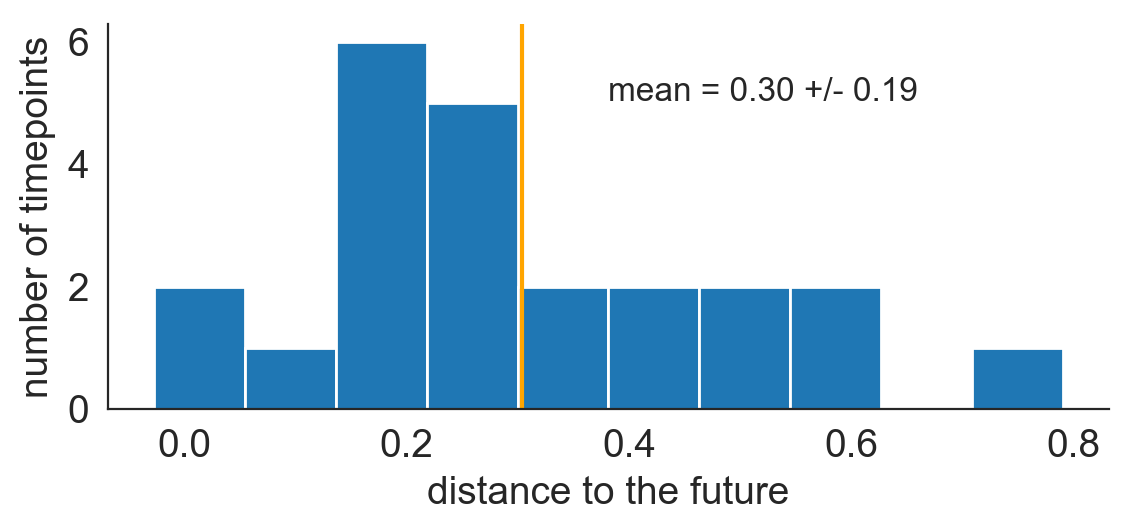

In [25]:
naive_luksza_errors_by_time_df = luksza_errors_by_time_df[luksza_errors_by_time_df["predictors"] == "naive"]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(naive_luksza_errors_by_time_df, bins=10)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_luksza_errors_by_time_df.mean()
std_y = naive_luksza_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange"
)

ax.text(
    0.5,
    0.8,
    "mean = %.2f +/- %.2f" % (mean_y, std_y),
    transform=ax.transAxes,
    fontsize=12,
    horizontalalignment="left"
)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-luksza-lassig-populations-between-timepoints.png")

## Figure 2: Summary of models for simulated populations

In [26]:
simulated_errors_by_time_df.head()

predictors  validation_error  validation_n validation_timepoint       type  \
0      naive         -0.046196           101           2018-10-01  simulated   
1      naive         -0.088974           102           2019-04-01  simulated   
2      naive         -0.052009            99           2019-10-01  simulated   
3      naive         -0.028453           100           2020-04-01  simulated   
4      naive          0.073000           102           2020-10-01  simulated   

               sample  
0  simulated_sample_0  
1  simulated_sample_0  
2  simulated_sample_0  
3  simulated_sample_0  
4  simulated_sample_0

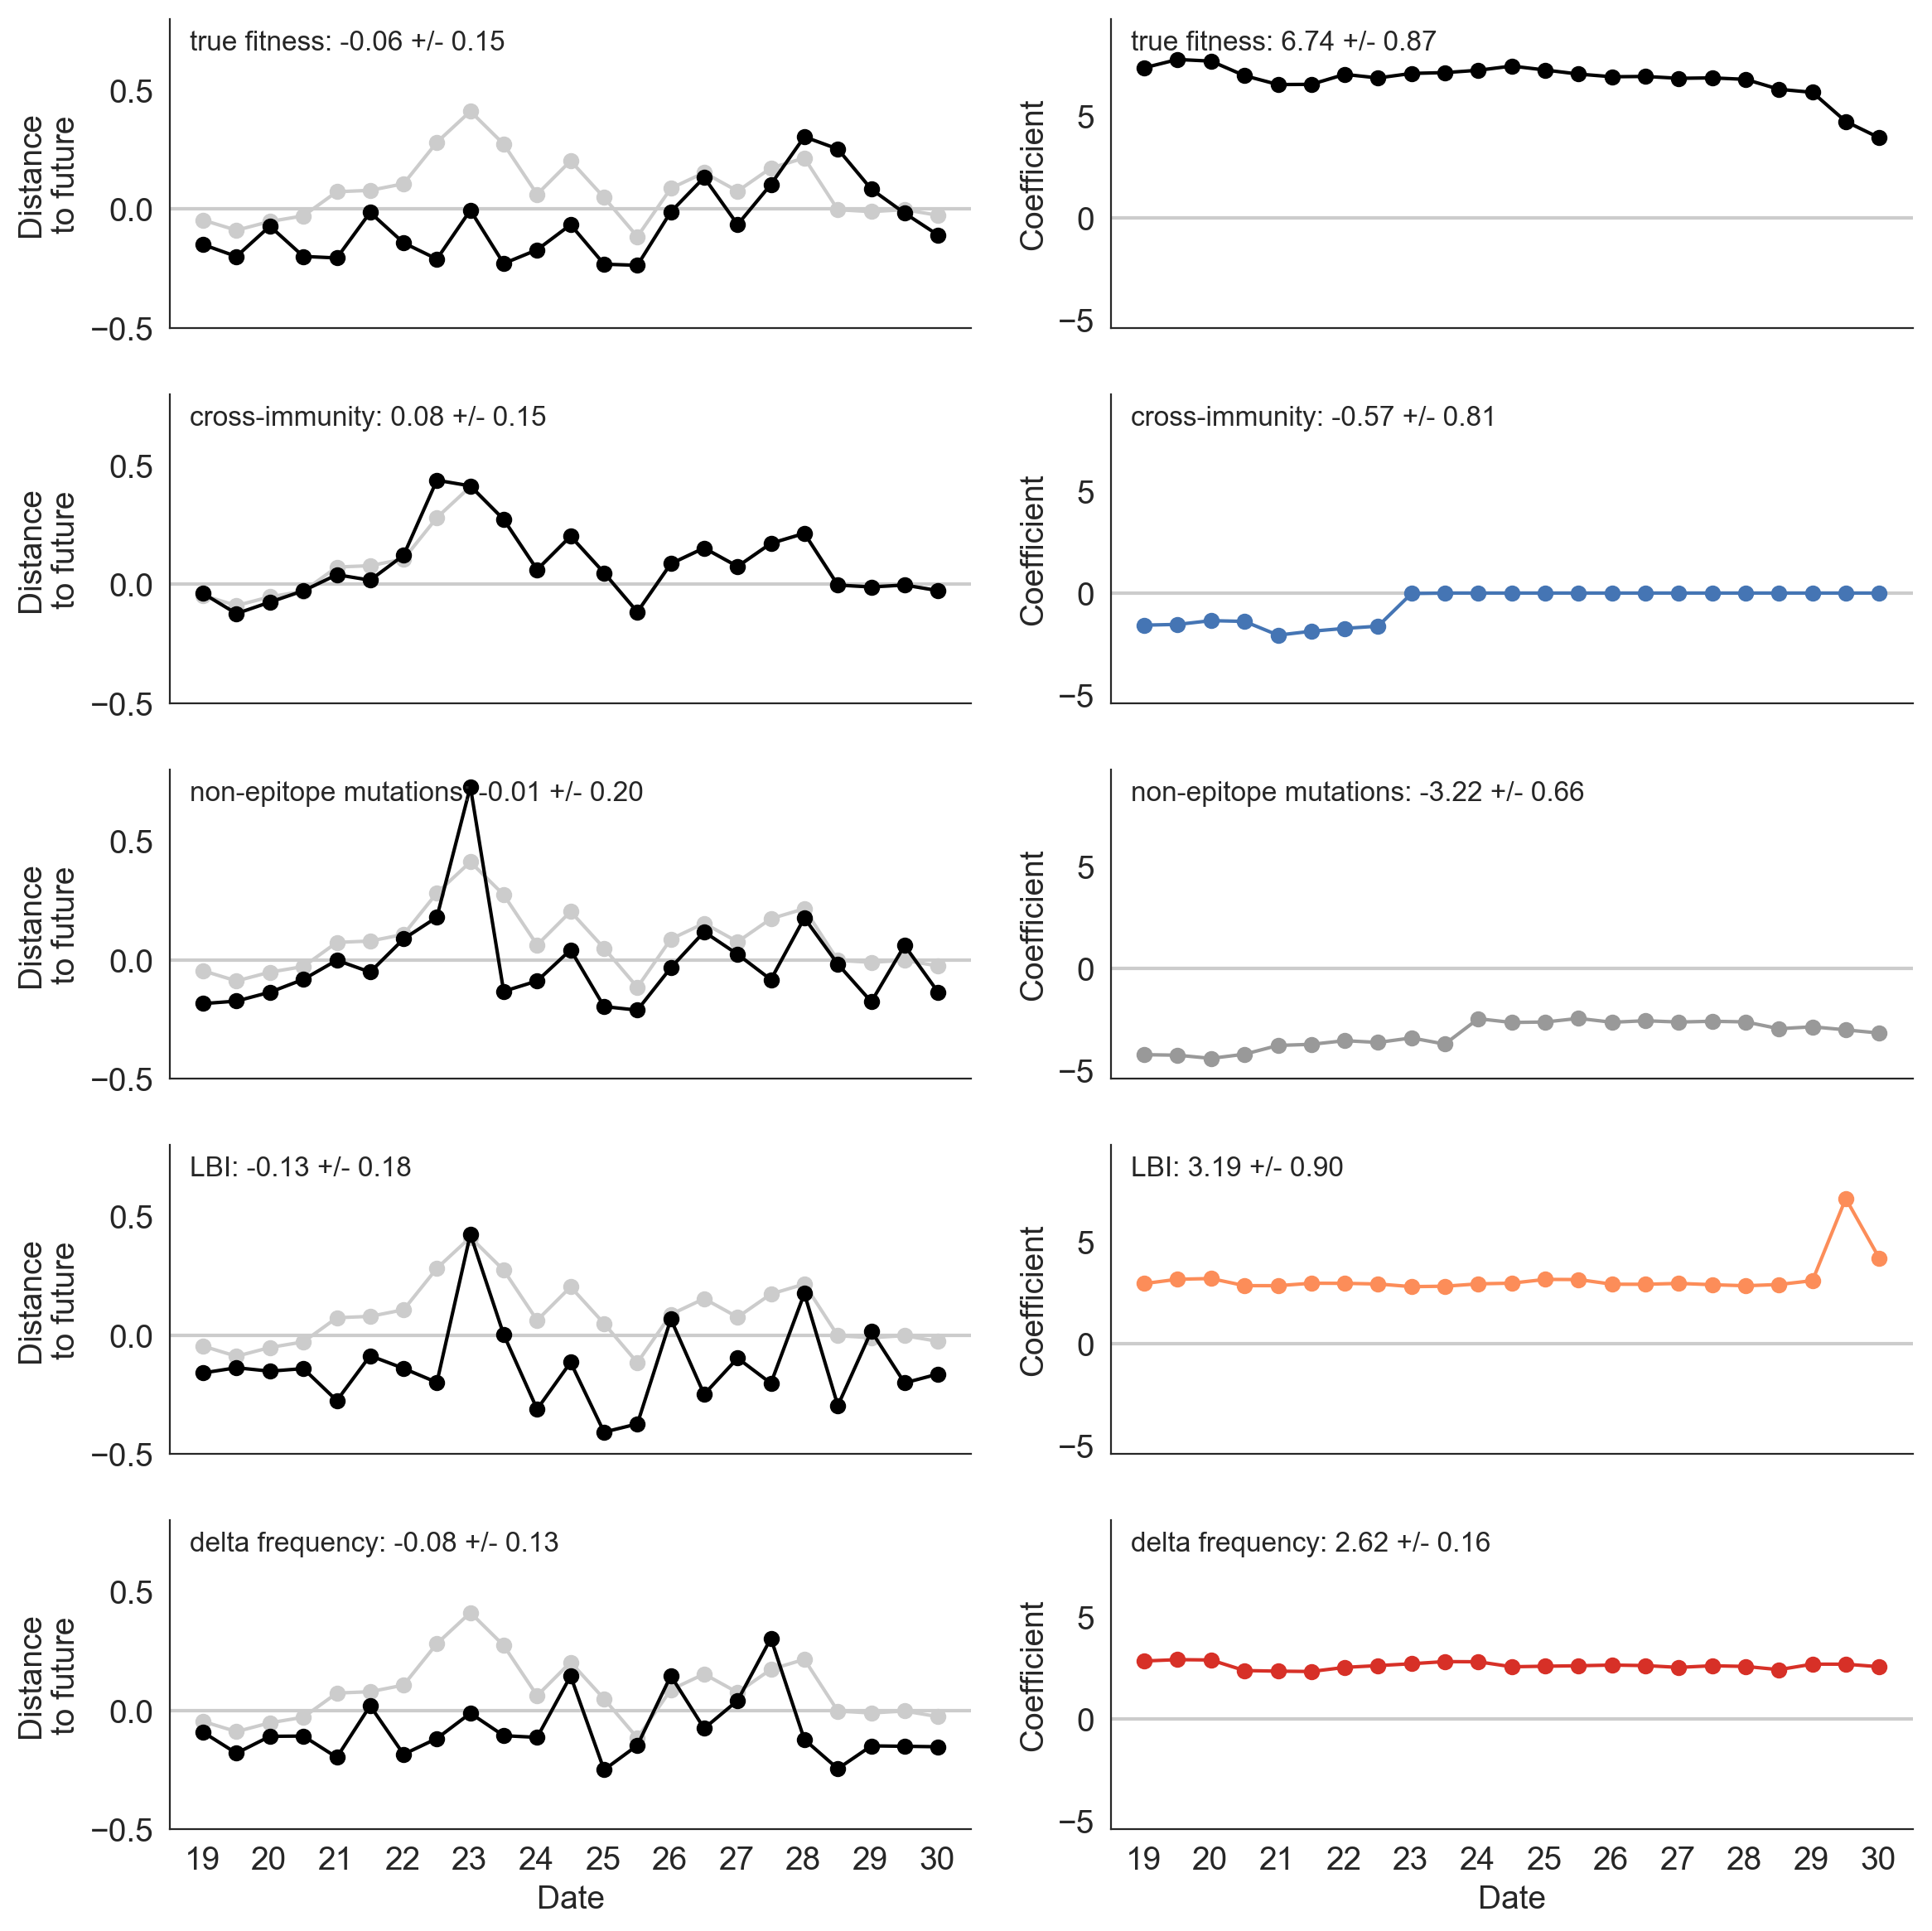

In [27]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    simulated_errors_by_time_df,
    simulated_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(simulated_errors_by_time_df),
    rotation=0,
    years_fmt_string="%y",
    date_fmt_string="%y-%m"
)
plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-simulated-populations.png")

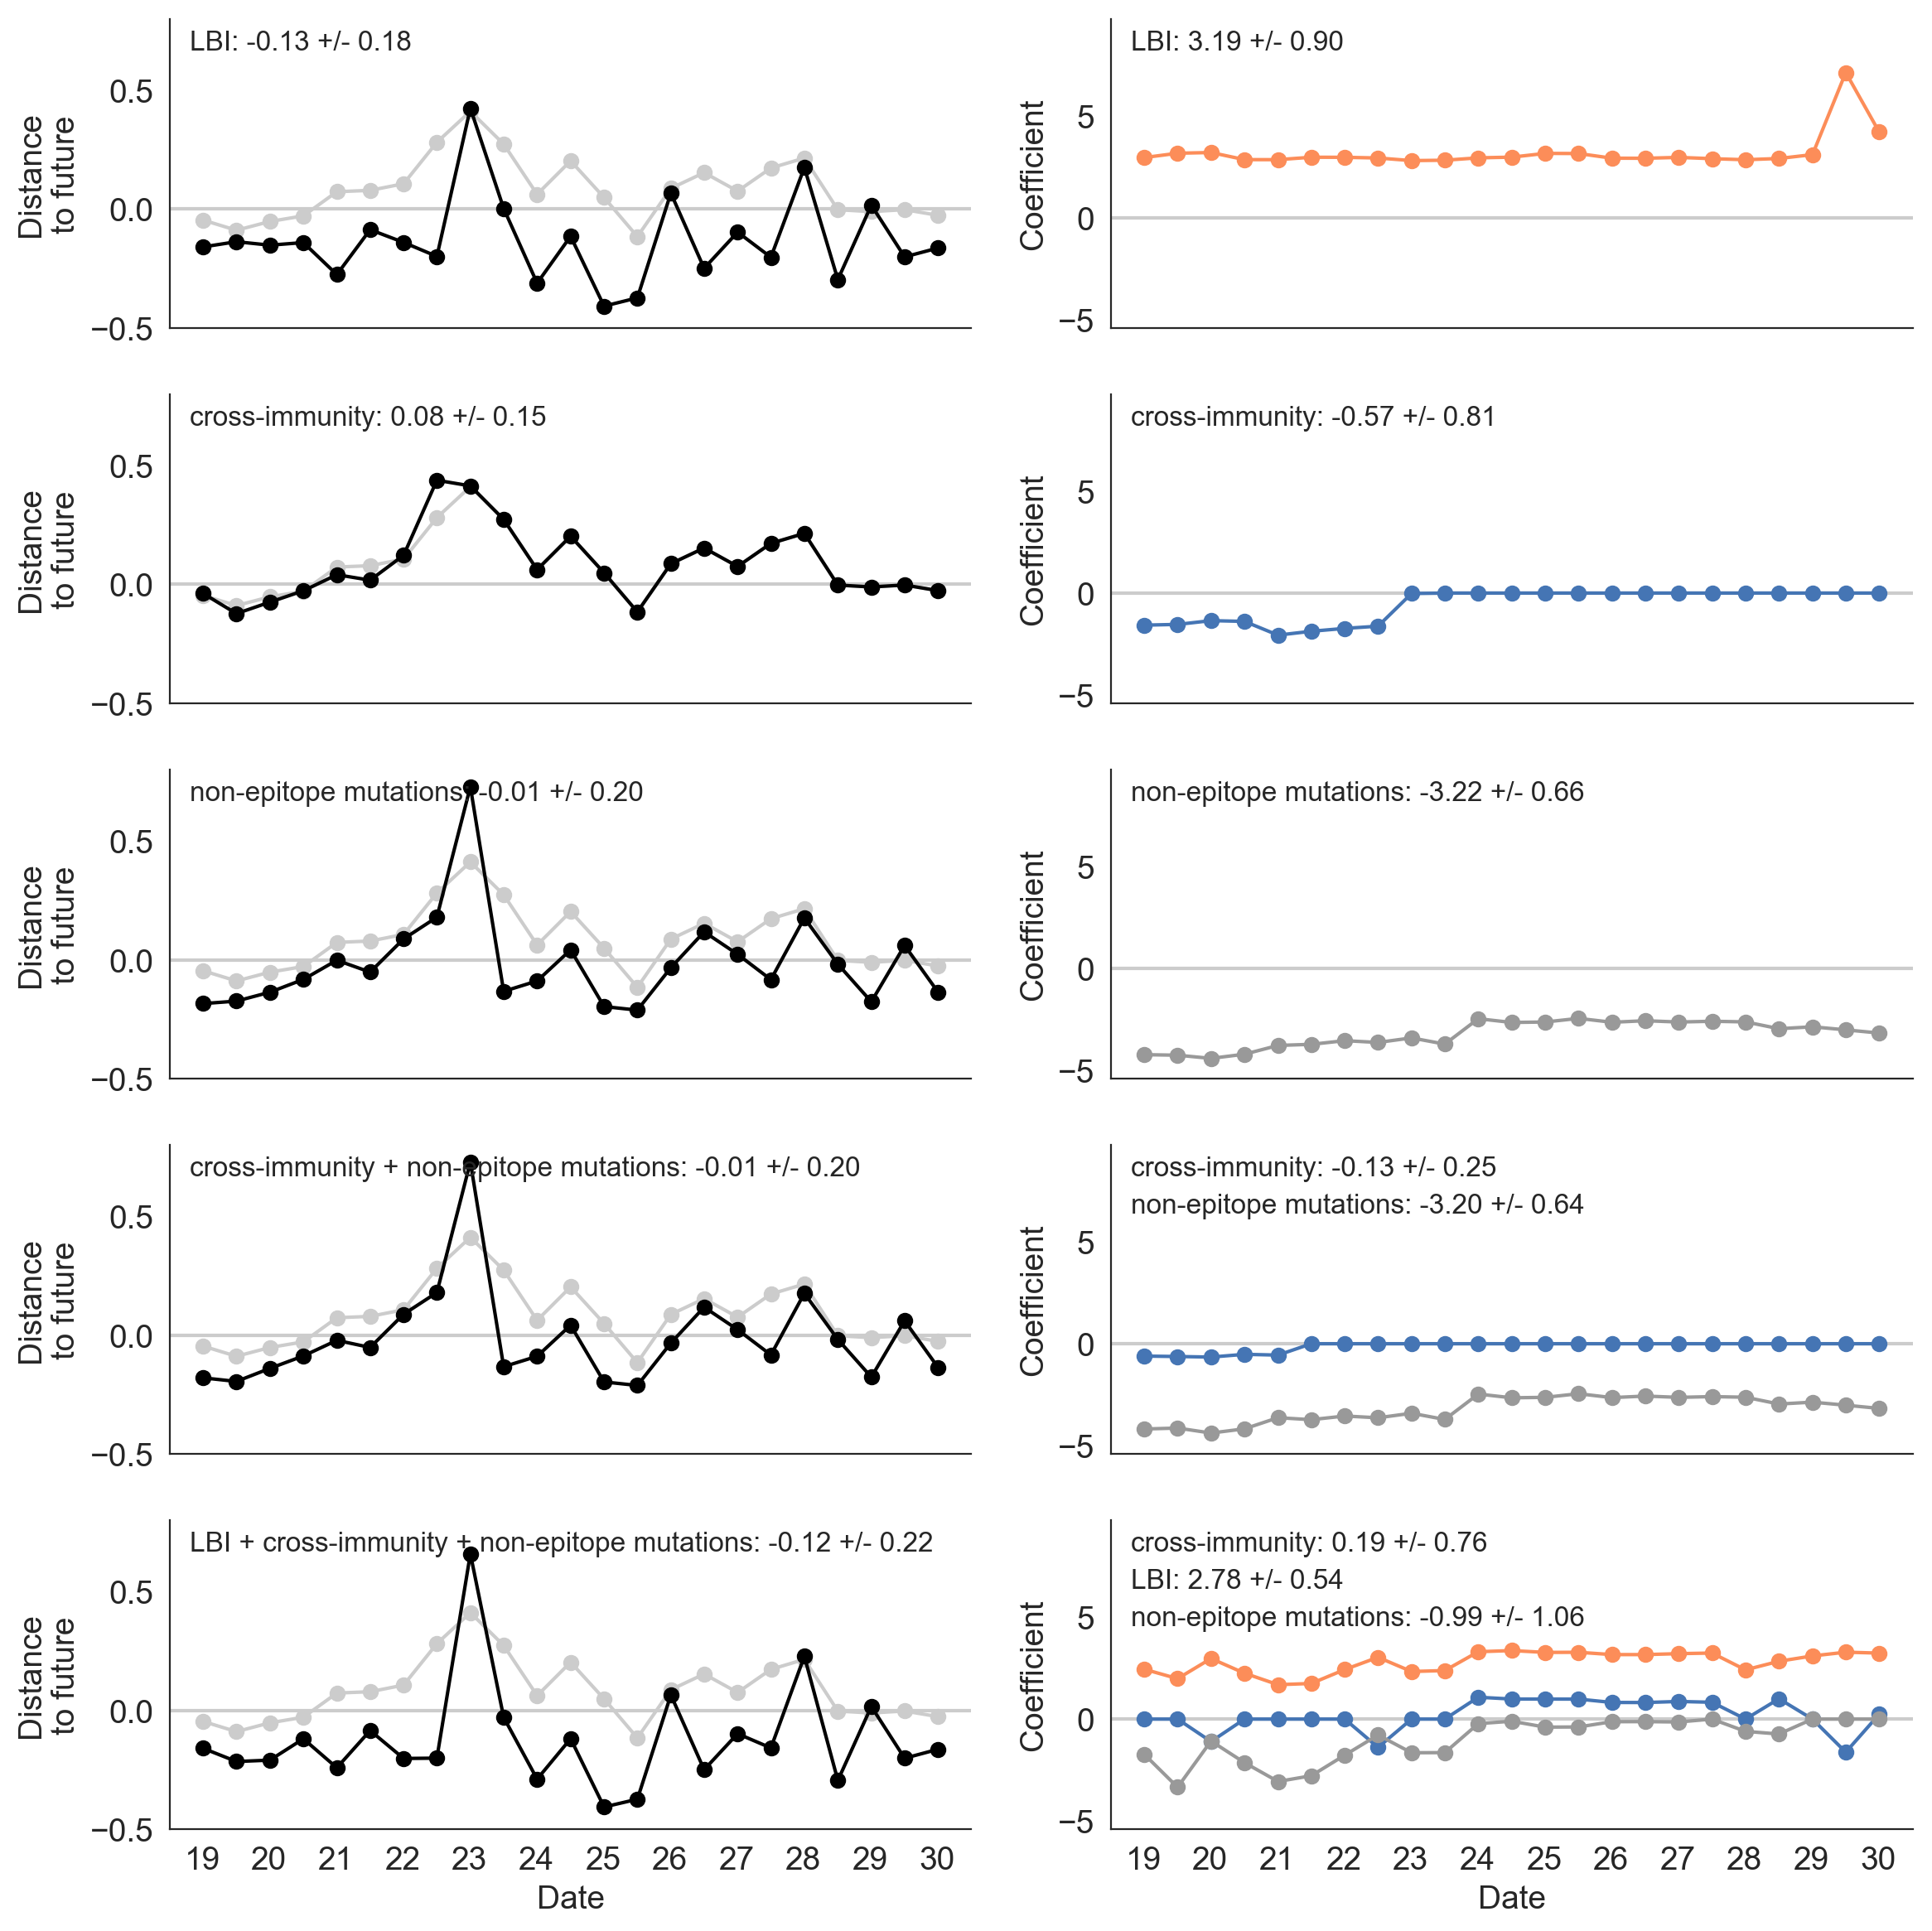

In [28]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    simulated_errors_by_time_df,
    simulated_coefficients_by_time_df,
    ["lbi", "ep_x", "ne_star"] + get_composite_predictors_for_data_frame(simulated_errors_by_time_df),
    rotation=0,
    years_fmt_string="%y",
    date_fmt_string="%y-%m"
)
plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-simulated-populations.png")

## Figure 3: Summary of models for natural populations

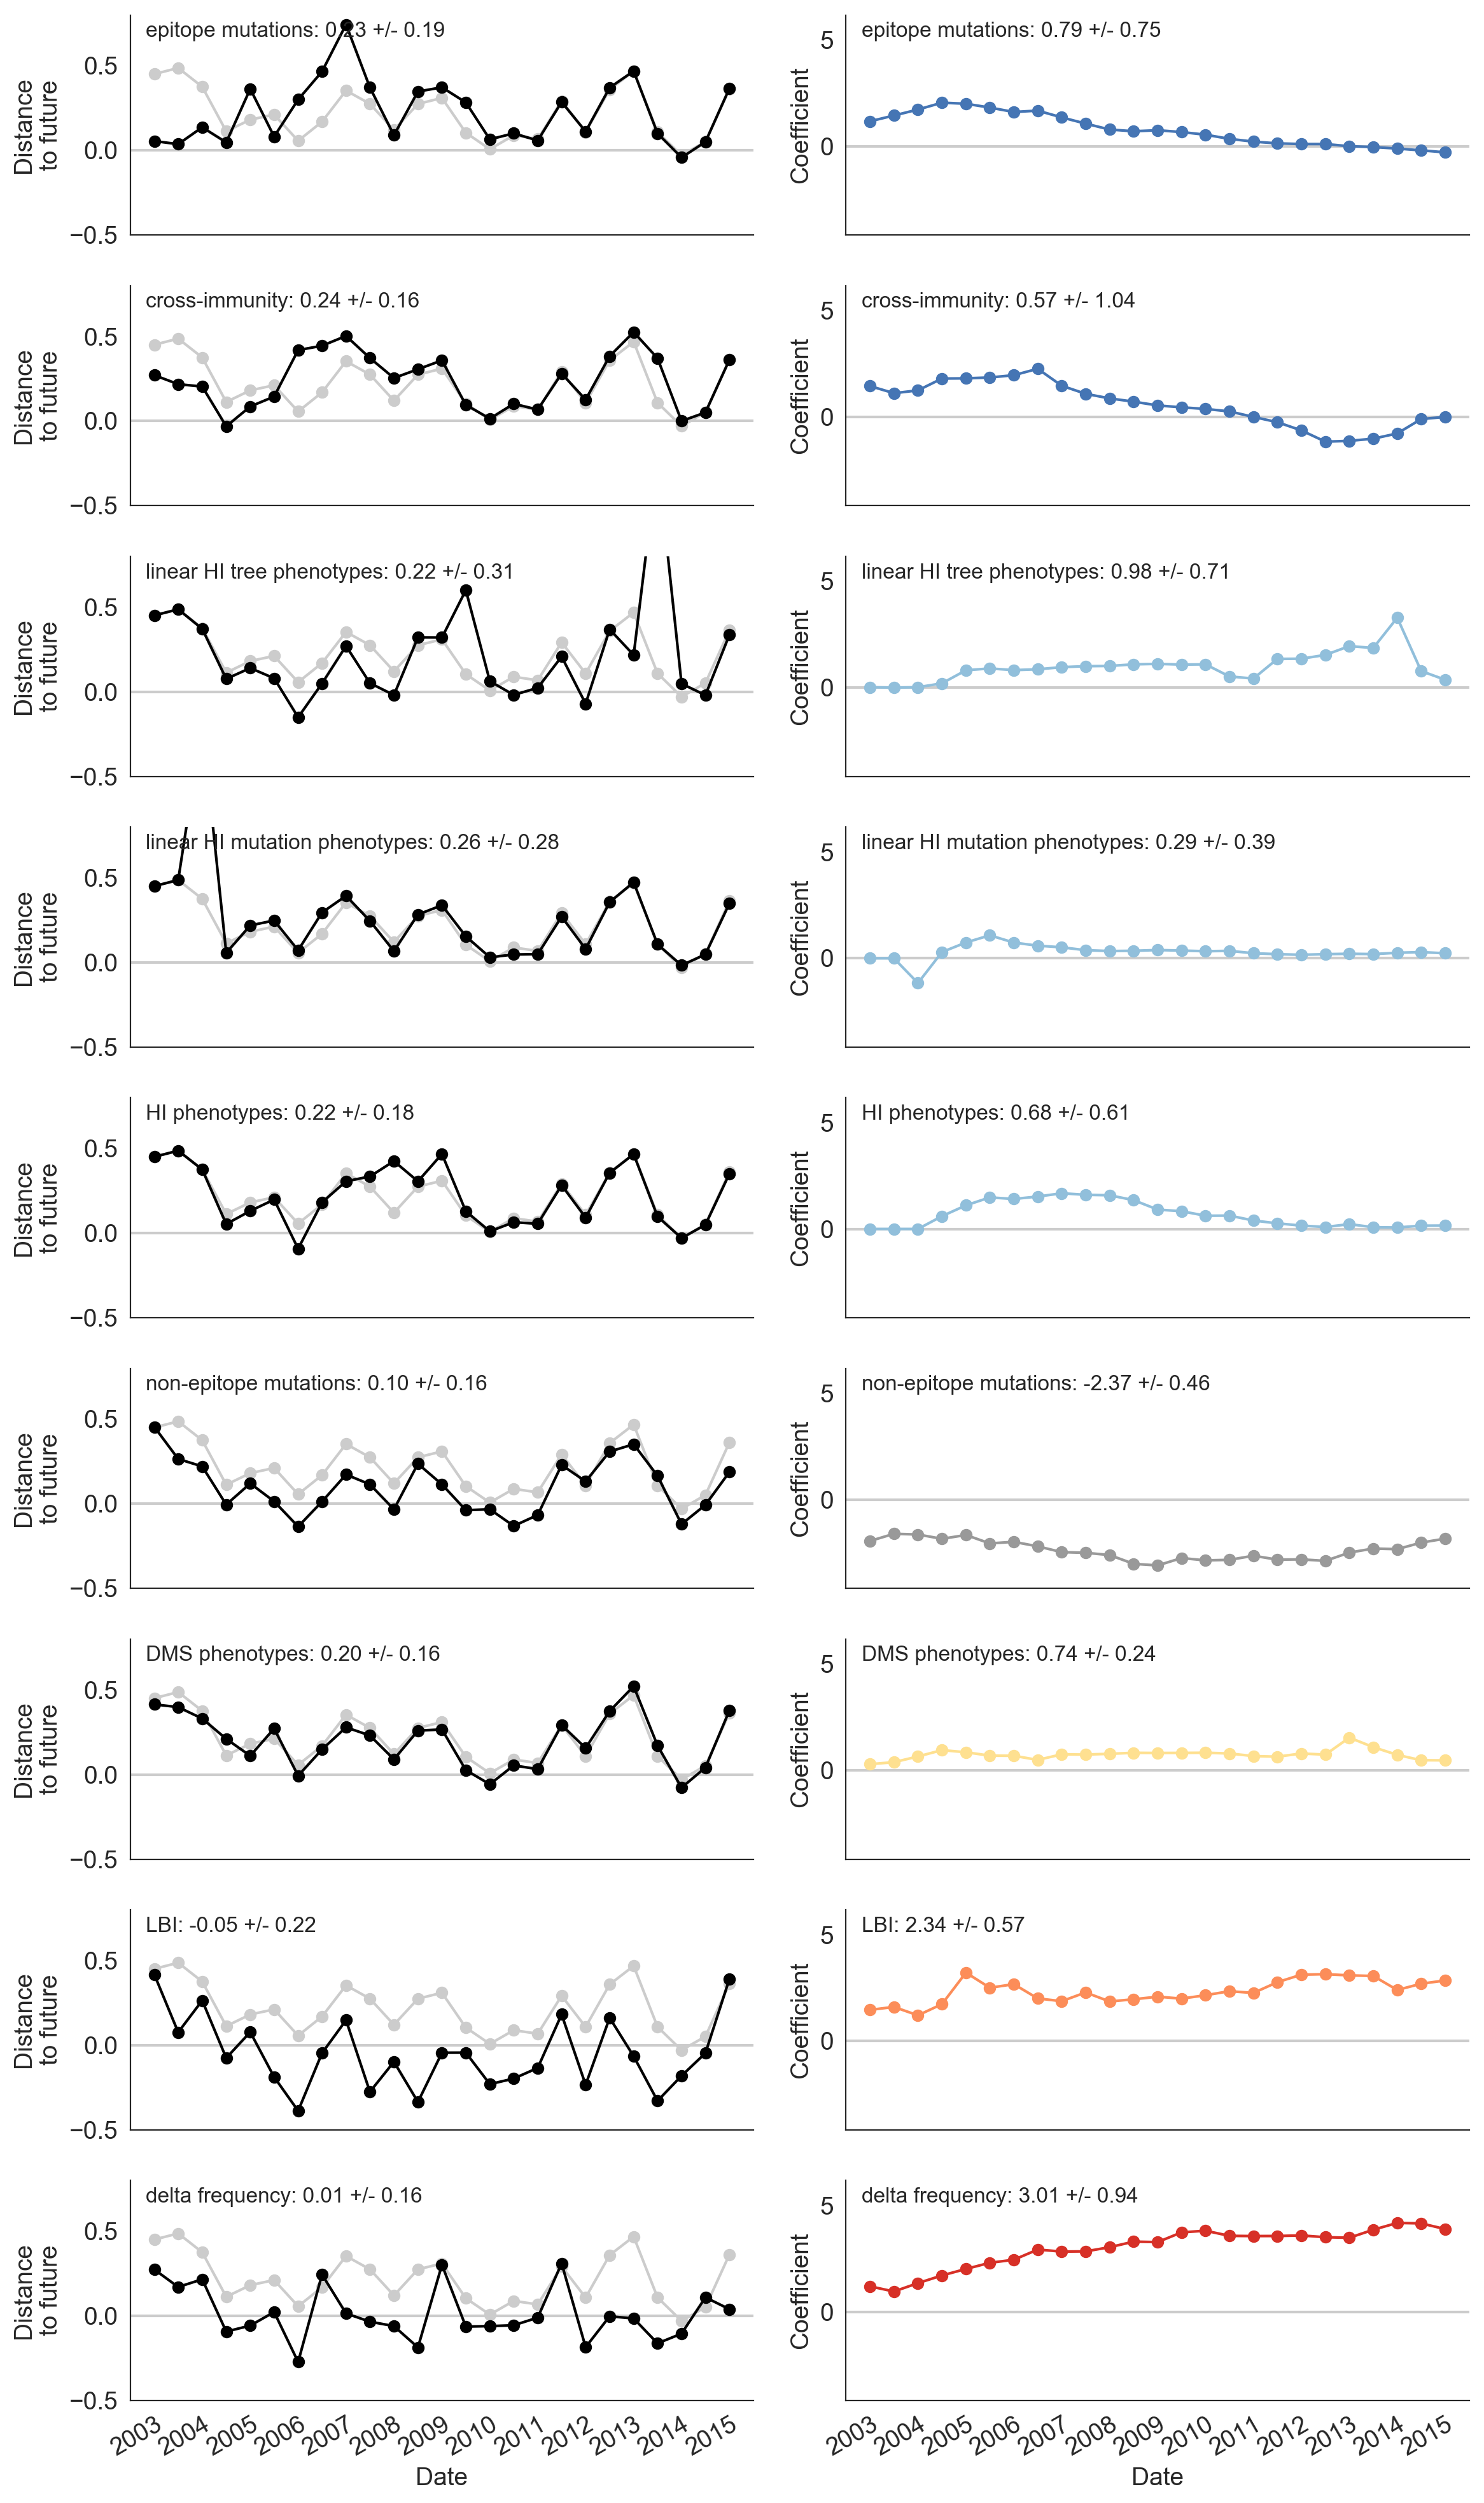

In [34]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(natural_errors_by_time_df),
    height=20
)
#plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

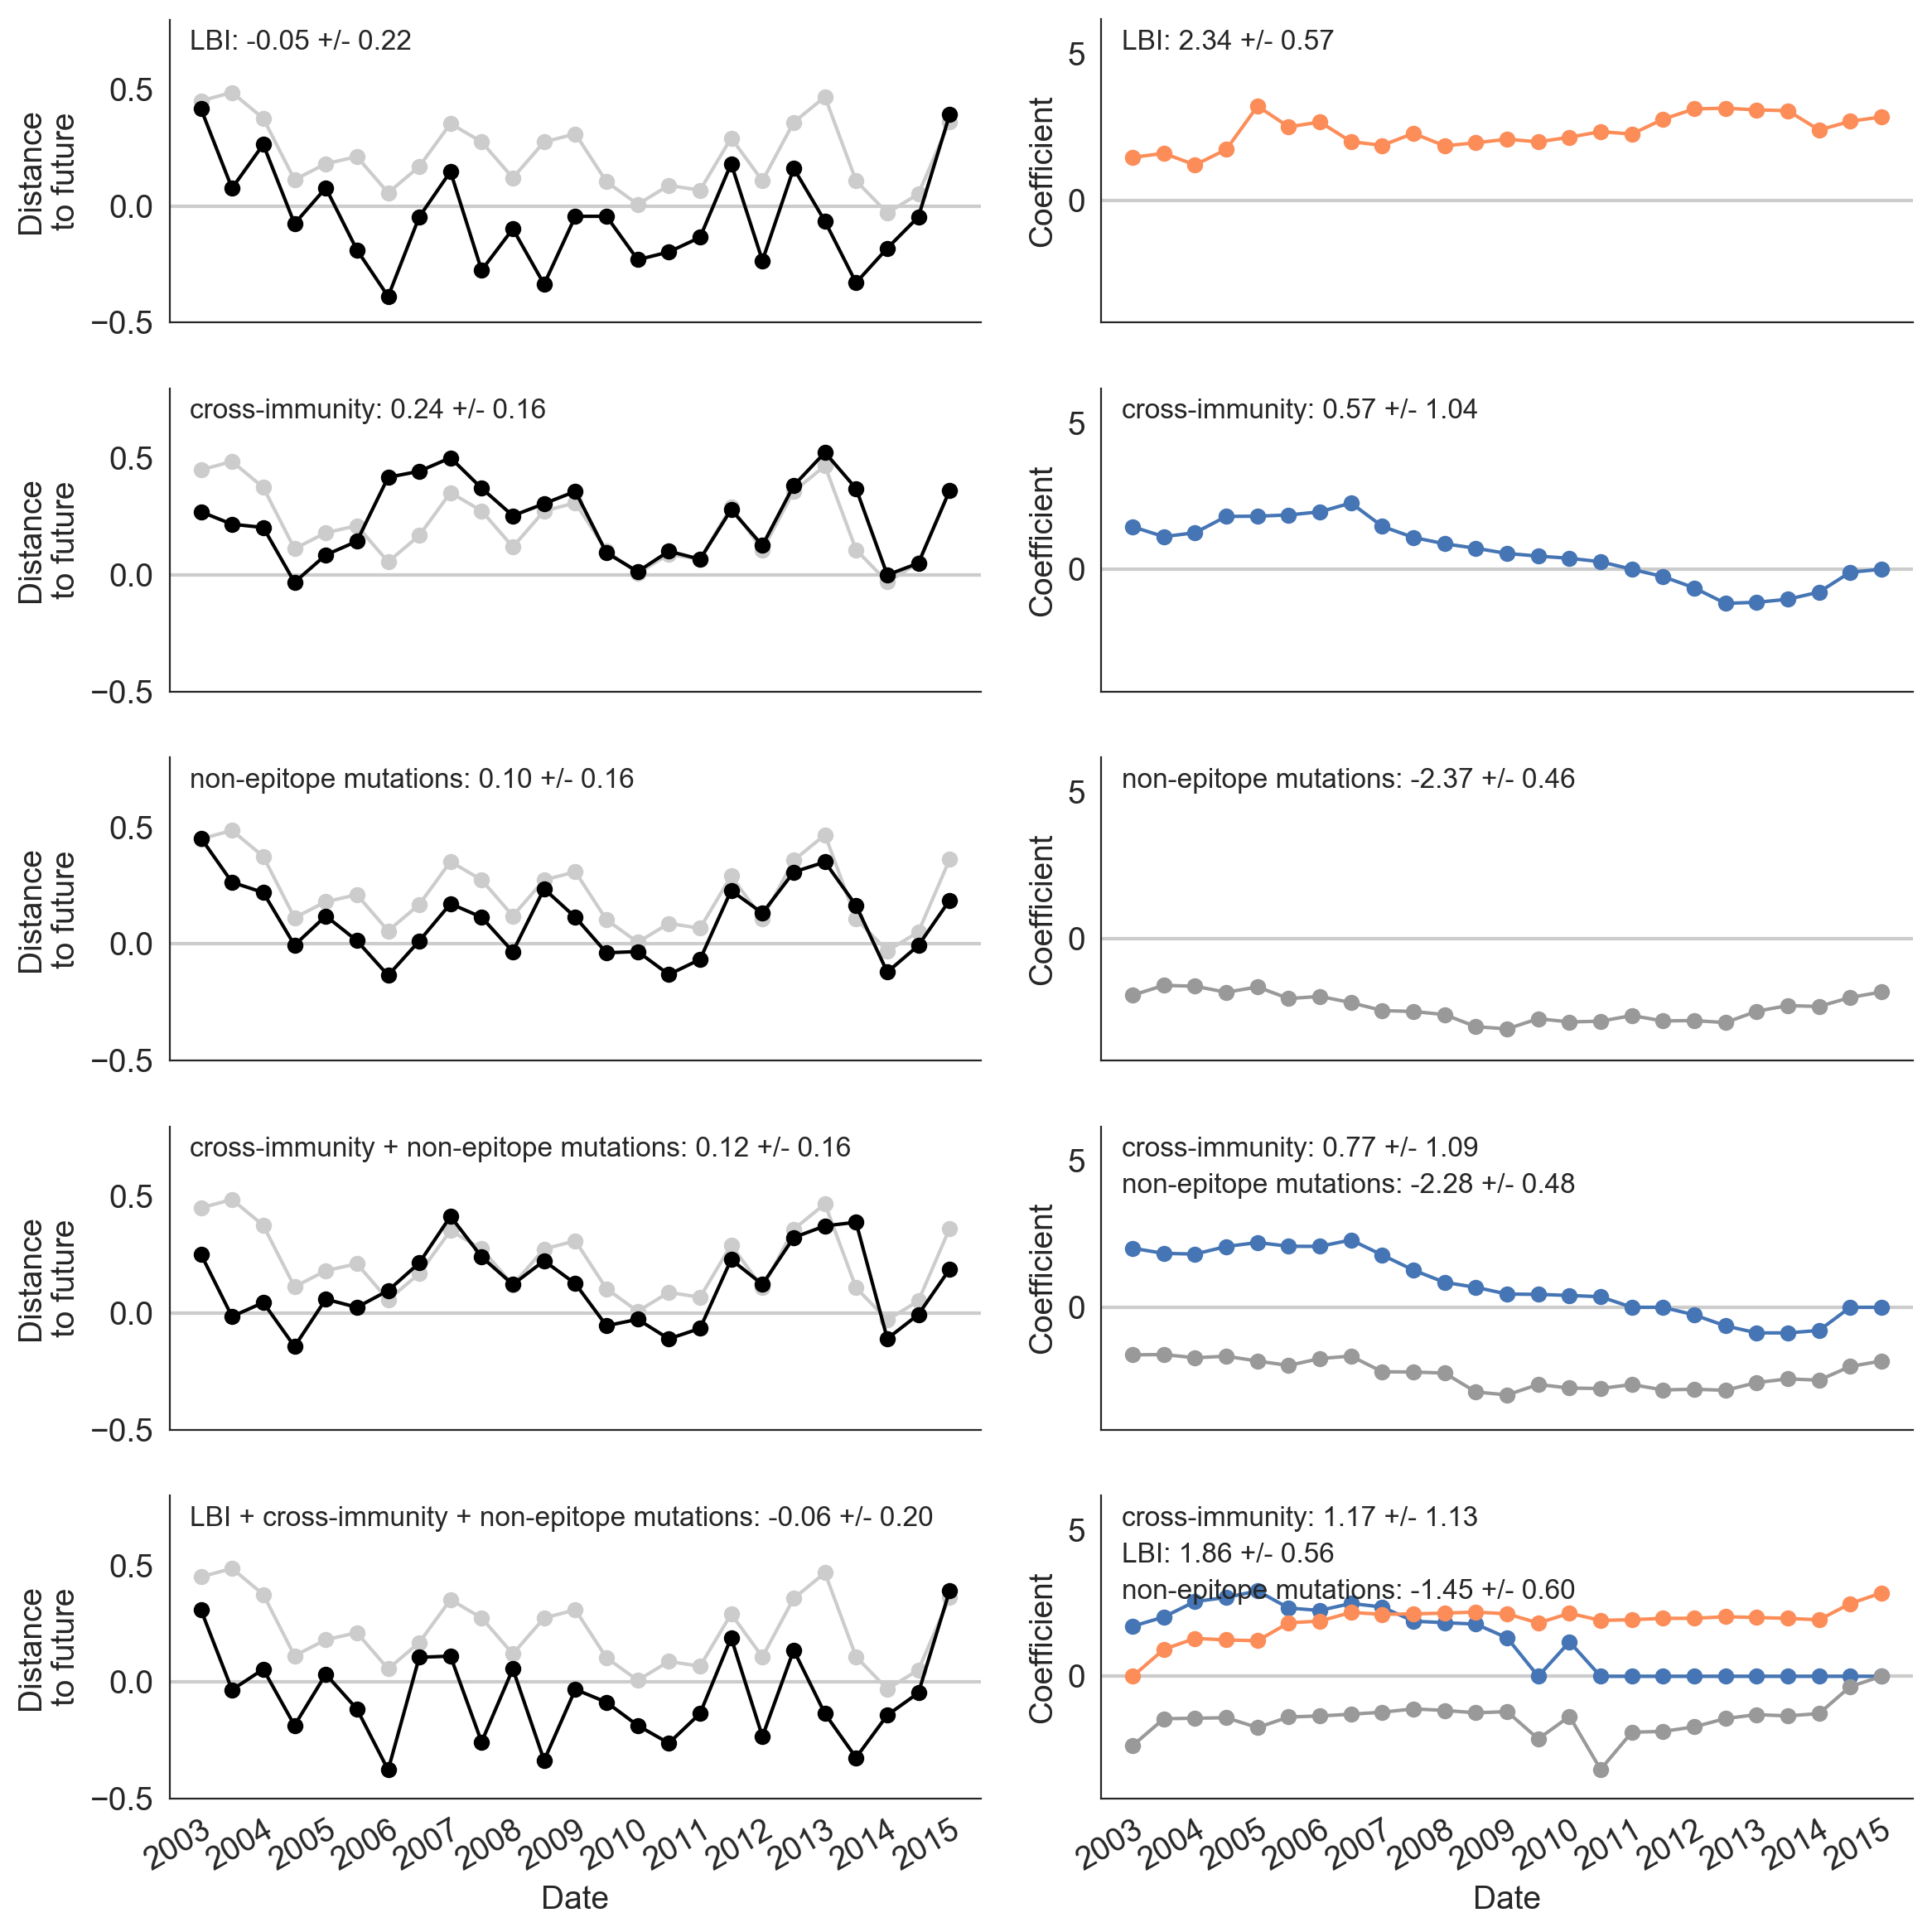

In [30]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["lbi", "ep_x", "ne_star"] + get_composite_predictors_for_data_frame(natural_errors_by_time_df)
)
#plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-natural-populations.png")

## Figure 4: Summary of models for Luksza and Lassig populations

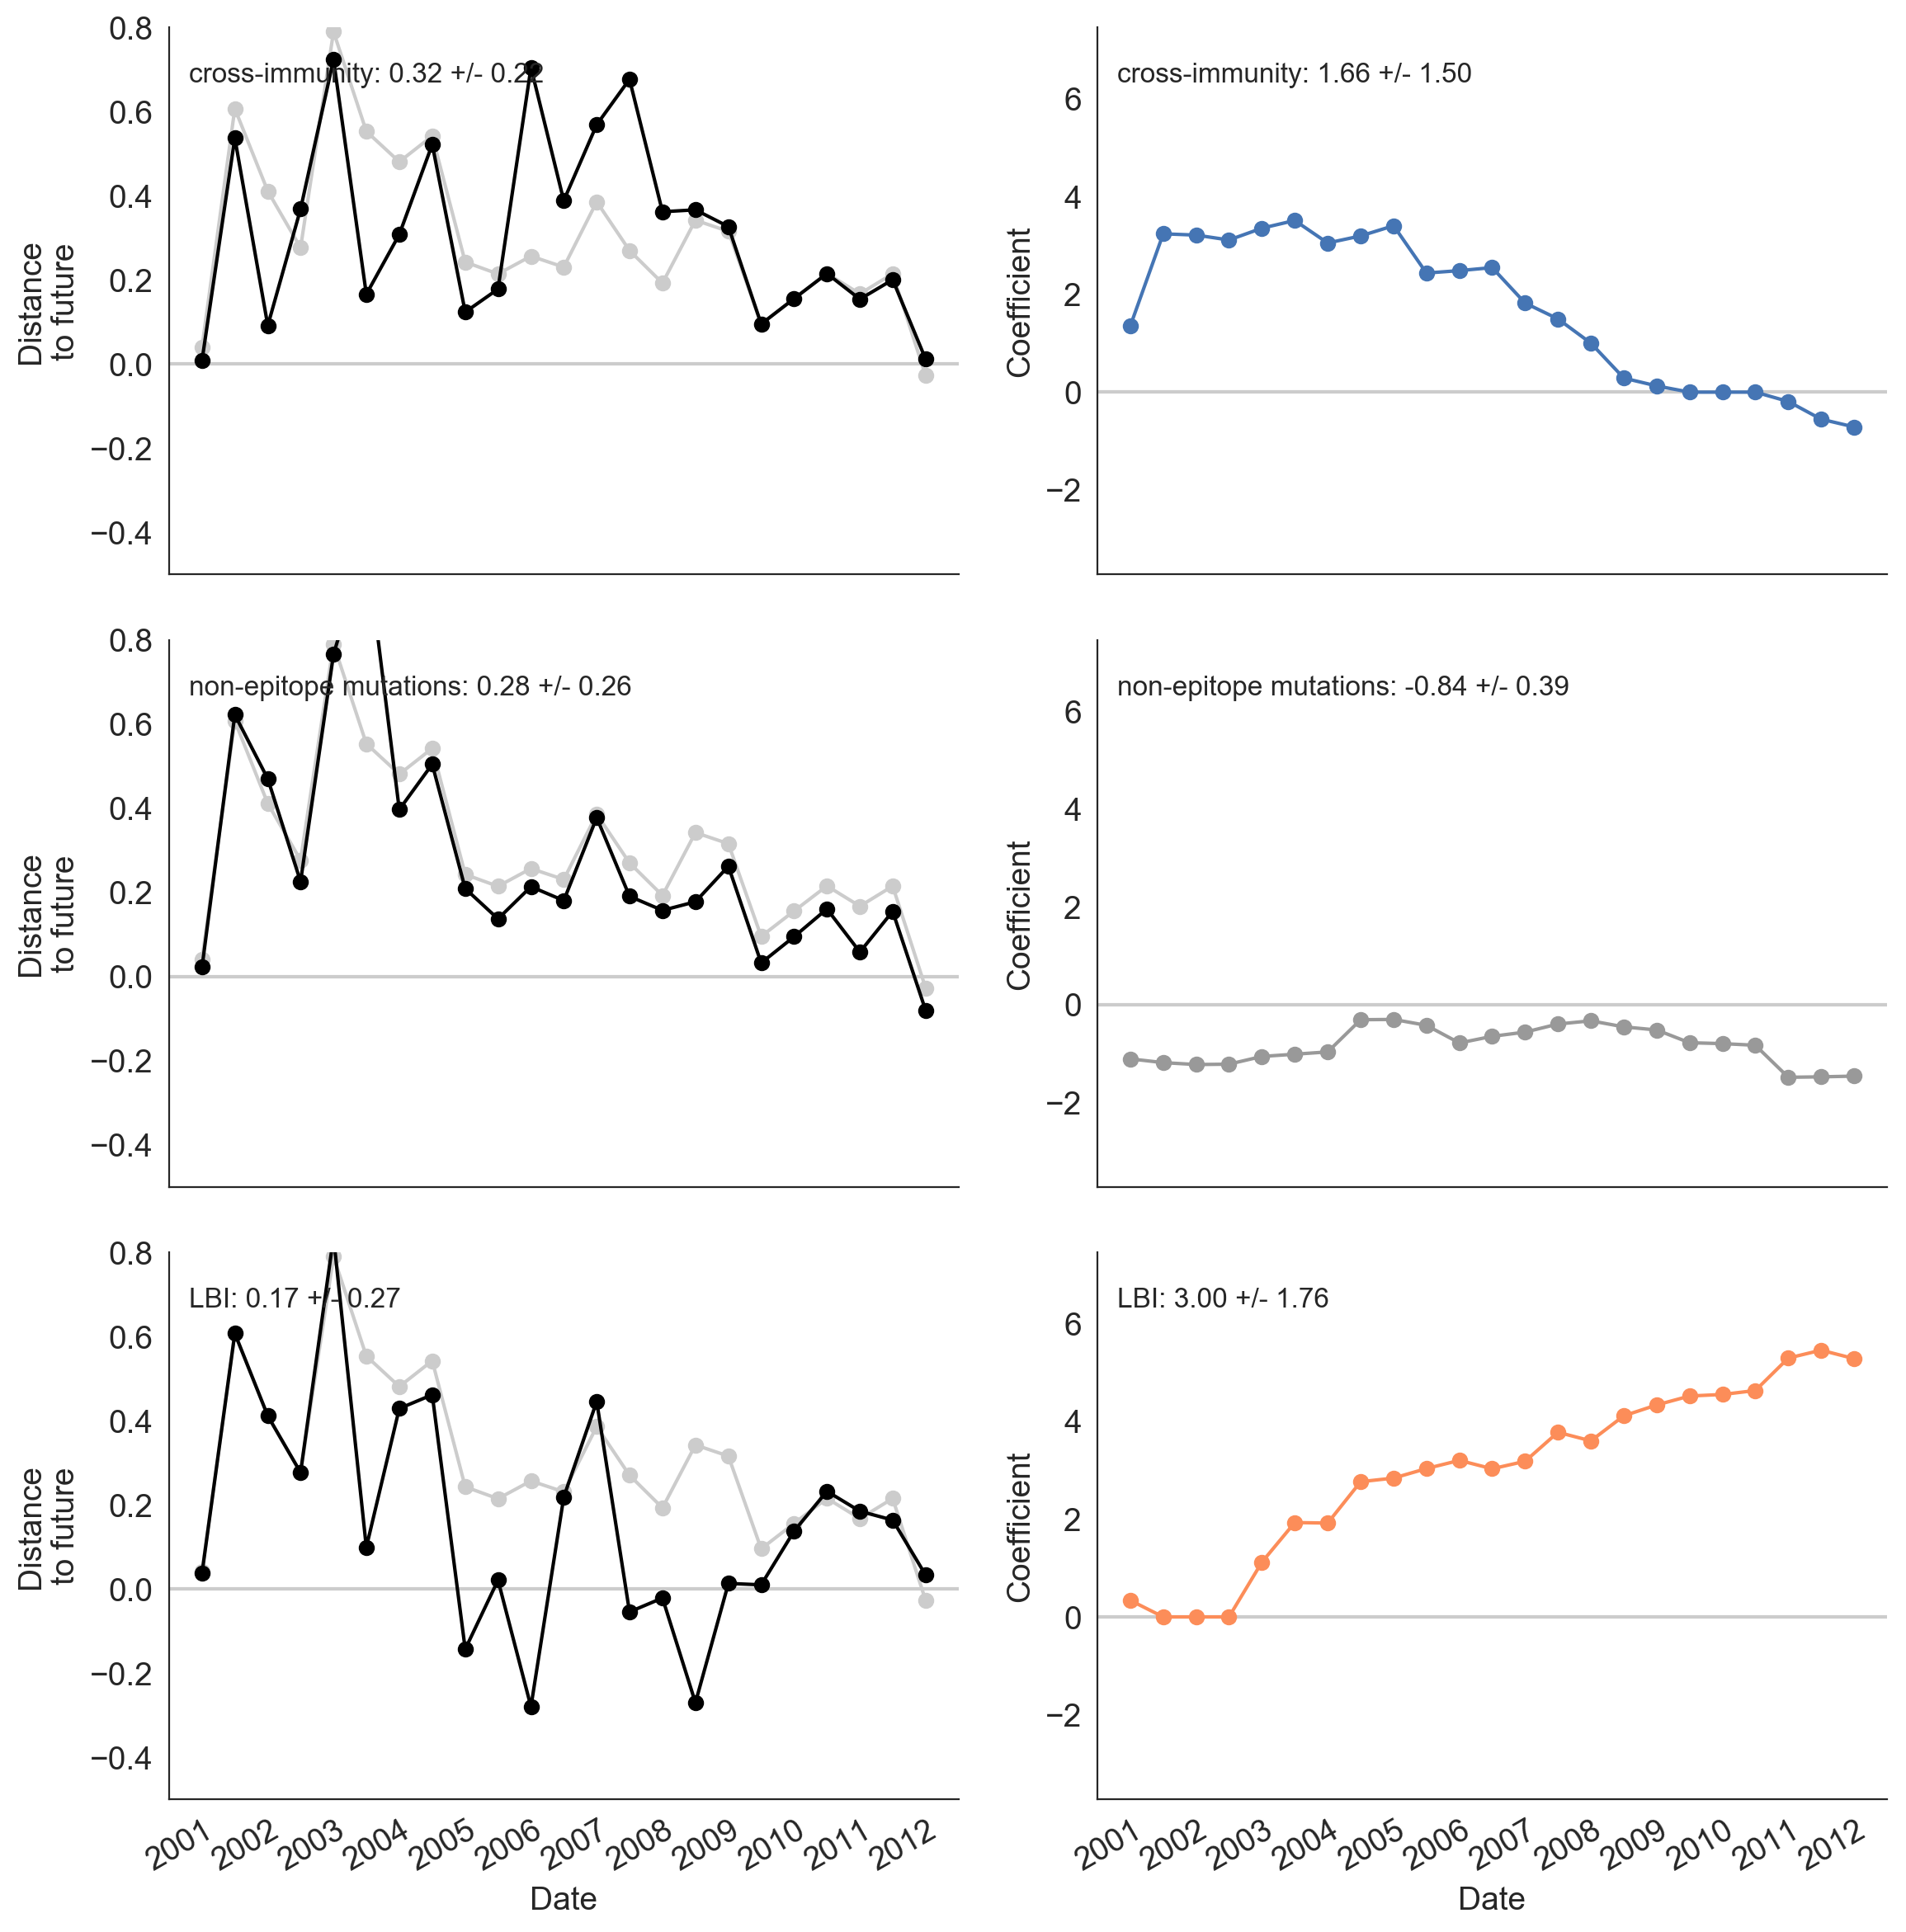

In [31]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    luksza_errors_by_time_df,
    luksza_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(luksza_errors_by_time_df)
)
plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-luksza-lassig-populations.png")

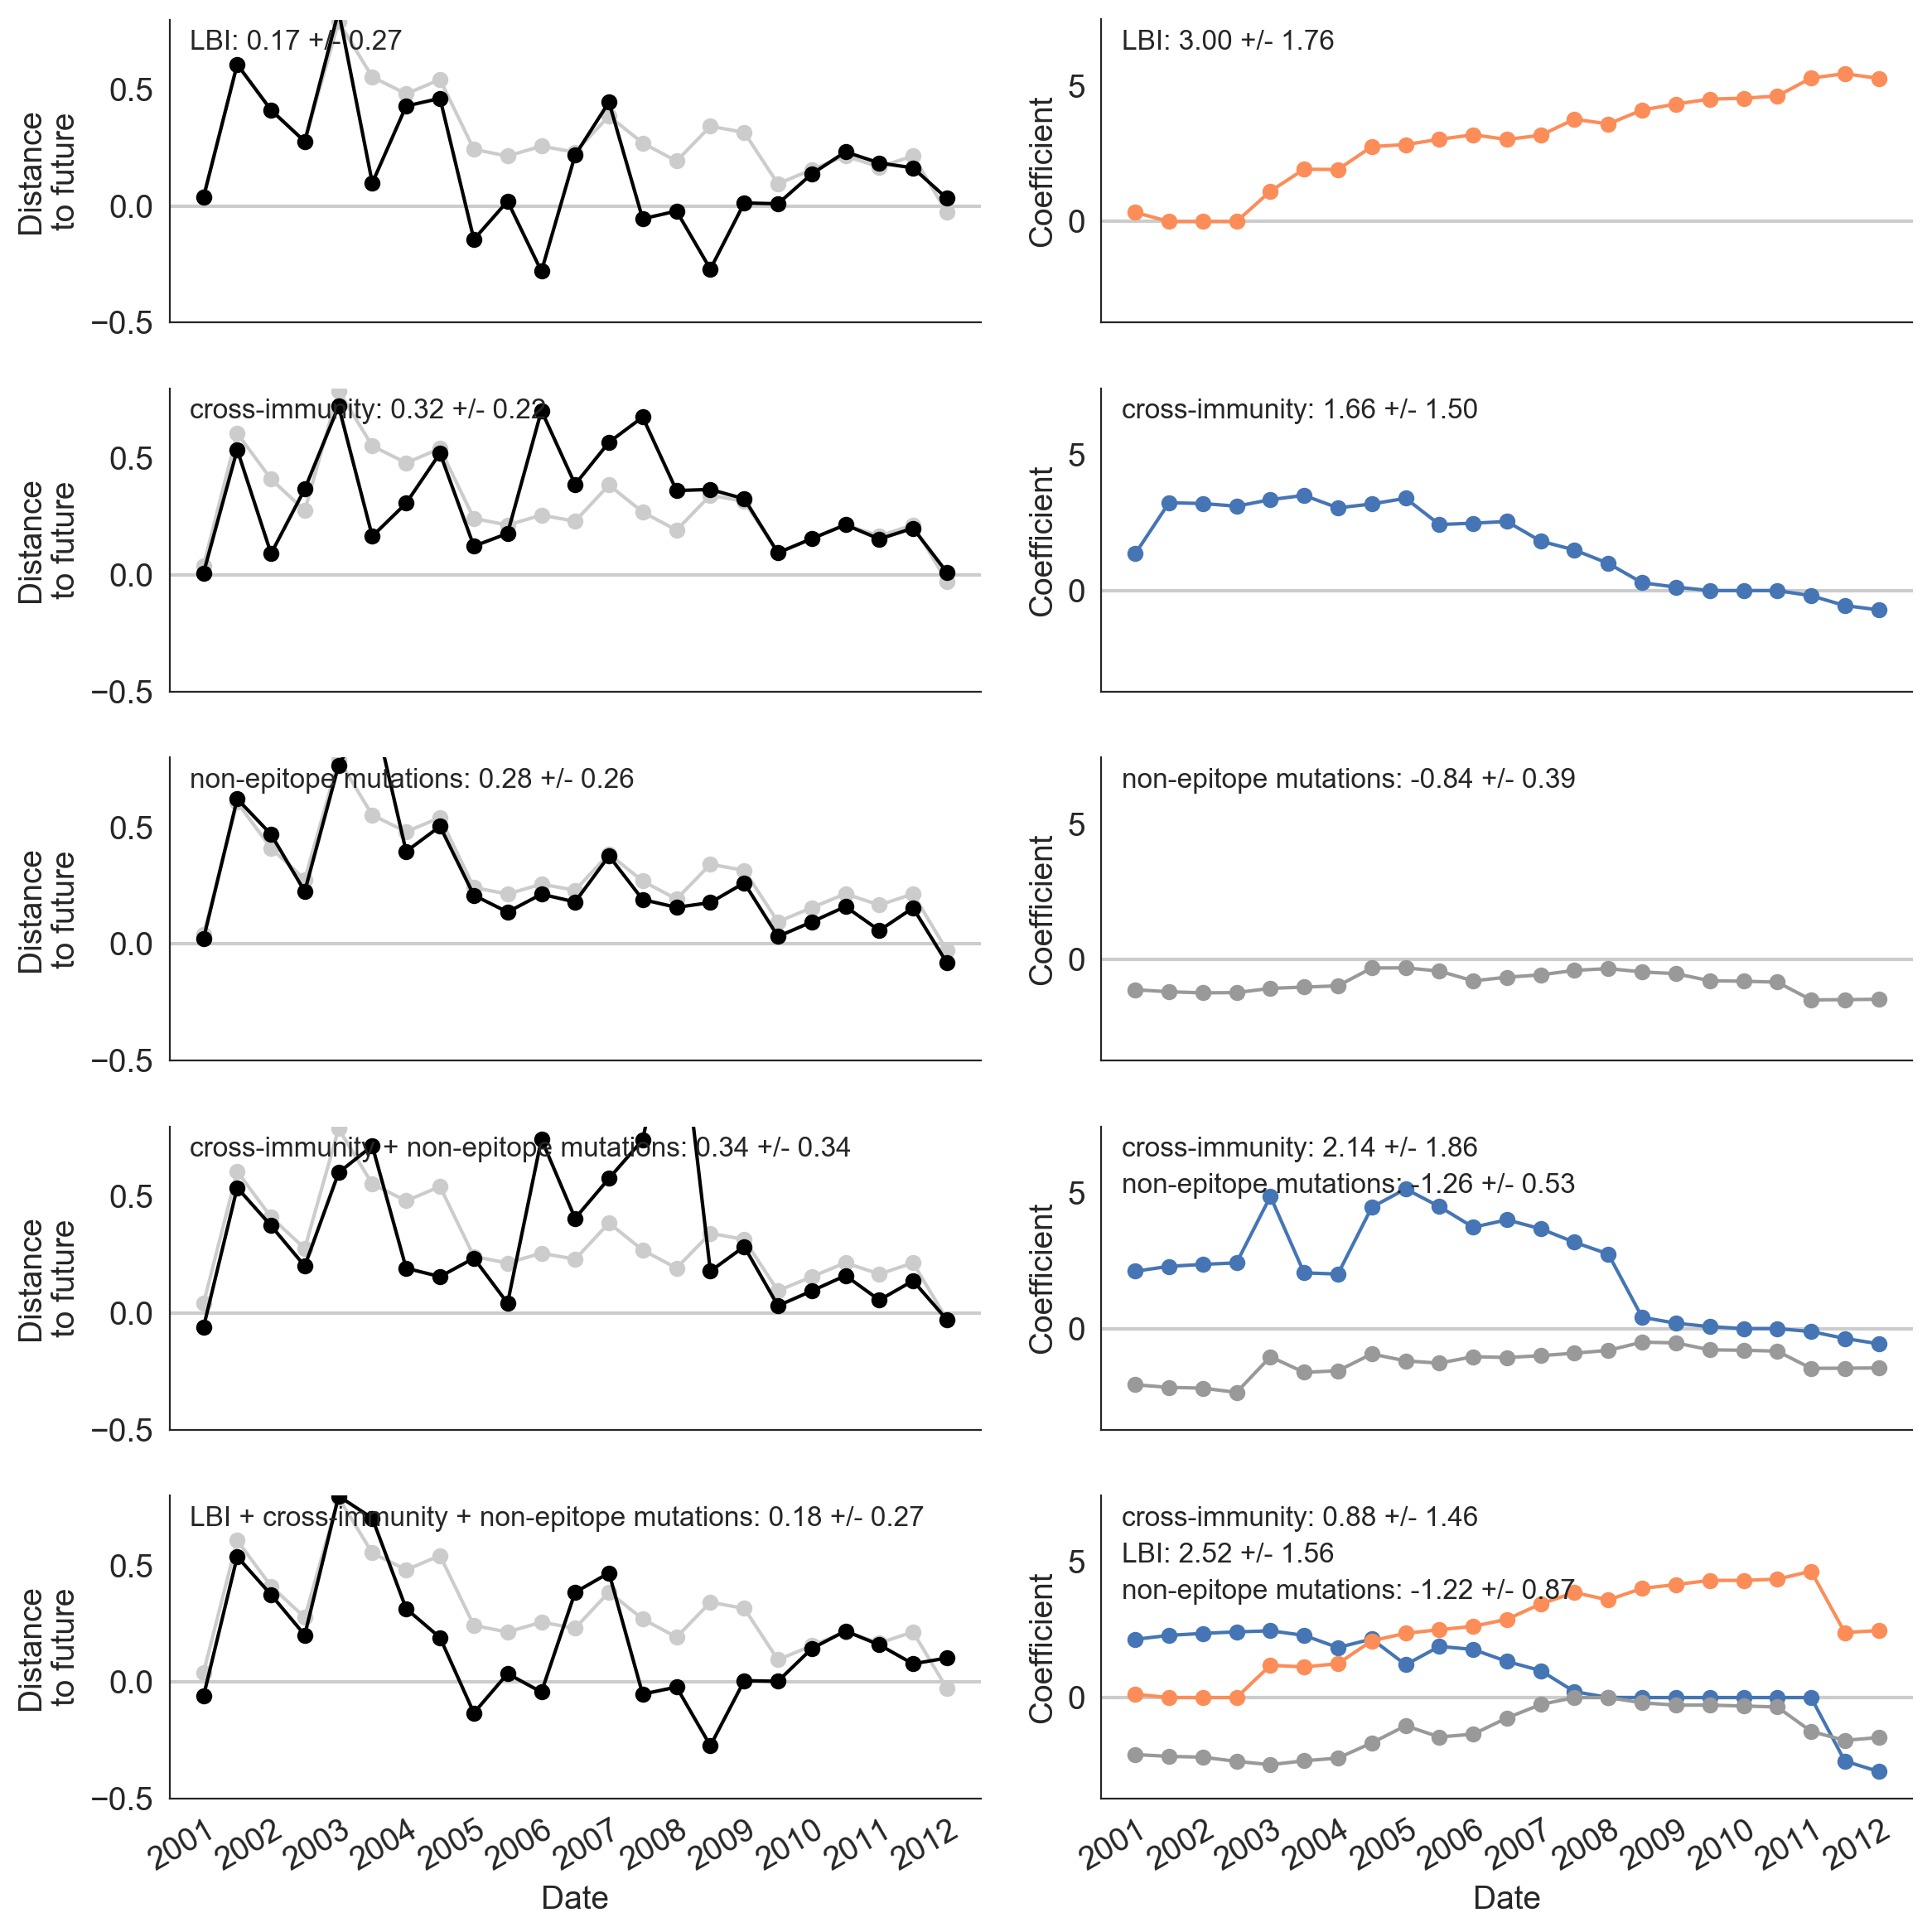

In [32]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    luksza_errors_by_time_df,
    luksza_coefficients_by_time_df,
    ["lbi", "ep_x", "ne_star"] + get_composite_predictors_for_data_frame(luksza_errors_by_time_df)
)
plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-luksza-lassig-populations.png")